# DATASCI W261, Machine Learning at Scale
--------
#### Assignement:  week \#2
#### Shih Yu Chang
### Due: 2016-09-13, 8AM PST

### *HW2.0.*
- What is a race condition in the context of parallel computation? Give an example.
- What is MapReduce?
- How does it differ from Hadoop?
- Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

- A race condition refers to the ssituation where the output is dependent on the sequence or timing of other uncontrollable events. For example, when a few paralle threads have interaction with some common resource, due to the lack of coordination and synchronization, the execution can cause invalid state of the resource, which can randomly affect the result of each thread. 

For example, consider the following logic, where B is a global counter variable:

temp = B
temp = temp + 1
B = temp
It will increase the value of B by one. If it is run twice sequentially, B will be increased by two. However, if two threads are running it at the same time, there is a chance that B will only be increased by one, not two.

- MapReduce is a programming framework for processing large data sets with a parallel, distributed algorithm on a cluster. It has two phases:
 - Map(): performs filtering and sorting
 - Reduce(): performs a summary operation
 
 
- Hadoop is an open source project which provides an implementation of the MapReduce functionality. It has two components:
 - HDFS: Hadoop distributed file system (Storage)
 - MapReduce implementation (Calculation)
 
Therefore, MapReduce is a calculating component of Hadoop 

- Hadoop is based on Functional Programing languages. key features of functional languages include (1) such language can accept other functions as arguments; (2) it is a declarative programming paradigm, which means programming is done with expressions. 
 - Example is given below:


In [17]:
# function to count character in a word
def char_count(word):
    return len(word)

# apply the function on a sentence
sentence = 'Run  both the Multinomial Naive Bayes and the Bernoulli Naive Bayes algorithms'
print('Count alphabeta numbers in each word of sentence: ')
print({word:char_count(word) for word in sentence.split()})

Count alphabeta numbers in each word of sentence: 
{'and': 3, 'both': 4, 'Run': 3, 'Multinomial': 11, 'Bernoulli': 9, 'Naive': 5, 'algorithms': 10, 'Bayes': 5, 'the': 3}


### HW2.1.1 Lower case and upper case sort. 


In [18]:
!curl 'http://www.gutenberg.org/cache/epub/11/pg11.txt' -o alicesTExtFilename.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  163k  100  163k    0     0  25509      0  0:00:06  0:00:06 --:--:--  107k


In [19]:
%%writefile pWordCount_n.sh
#!/bin/bash
## pWordCount.sh
## Author: James G. Shanahan
## Usage: pWordCount.sh m wordlist testFile.txt
## Input:
##       m = number of processes (maps), e.g., 4
##       wordlist = a space-separated list of words in quotes, e.g., "the and of"
##       inputFile = a text input file
##
## Instructions: Read this script and its comments closely.
##               Do your best to understand the purpose of each command,
##               and focus on how arguments are supplied to mapper.py/reducer.py,
##               as this will determine how the python scripts take input.
##               When you are comfortable with the unix code below,
##               answer the questions on the LMS for HW1 about the starter code.



if [ $# -eq 0 ]
  then
    echo "No arguments supplied"
    echo "To run use"  
    echo "     pWordCount.sh m wordlist inputFile"
    echo "Input:"
    echo "      number of processes (maps), e.g., 4"
    echo "      wordlist = a space-separated list of words in quotes, e.g., 'the and of'"
    echo "      inputFile = a text input file"
    exit
fi
    
    
## collect user input
m=$1 ## the number of parallel processes (maps) to run

wordlist=$2 ## if set to "*", then all words are used

## a text file  
data="alicesTExtFilename.txt"

## 'wc' determines the number of lines in the data
## 'perl -pe' regex strips the piped wc output to a number
linesindata=`wc -l $data | perl -pe 's/^.*?(\d+).*?$/$1/'`

## determine the lines per chunk for the desired number of processes
linesinchunk=`echo "$linesindata/$m+1" | bc`

## split the original file into chunks by line
split -l $linesinchunk $data $data.chunk.

## assign python mappers (mapper.py) to the chunks of data
## and emit their output to temporary files
for datachunk in $data.chunk.*; do
    ## feed word list to the python mapper here and redirect STDOUT to a temporary file on disk
    ####
    ####
    ./mapper_n.py $datachunk "$wordlist" > $datachunk.counts &
    ####
    ####
done

## wait for the mappers to finish their work
wait
    
## sorting keys (words) by alphbetaical order      
    

## 'ls' makes a list of the temporary count files
## 'perl -pe' regex replaces line breaks with spaces
countfiles=`\ls $data.chunk.*.counts | perl -pe 's/\n/ /'`

## feed the list of countfiles to the python reducer and redirect STDOUT to disk
####
####
./reducer_n.py $countfiles | grep -e "^[[:upper:]]" | sort -k1,1 > $data.outputU
./reducer_n.py $countfiles | grep -e "^[[:lower:]]" | sort -k1,1 > $data.outputL

####
####

## clean up the data chunks and temporary count files
rm $data.chunk.*
    



Overwriting pWordCount_n.sh


In [20]:
%%writefile mapper_n.py
#!/usr/bin/python
## mapper.py
## Given a file and list of words, read lines and count occurrences of words


import sys
import re

WORD_RE = re.compile(r"[\w']+")

filename = sys.argv[1]

## Words in the word list are space delimited
wordlist = sys.argv[2].split(' ')
counts = {}


with open (filename, "rU") as myfile:
    for text in myfile.readlines():  
        for word in WORD_RE.findall(text):
            if word in wordlist:
                try:
                    counts[word] += 1
                except:
                    counts[word] = 1

for word in counts:
    sys.stdout.write('{0}\t{1}\n'.format(word, counts[word]))
    


Overwriting mapper_n.py


In [21]:
%%writefile reducer_n.py
#!/usr/bin/python2
import sys
counts_U = {}
counts_L = {}

for intermediate_file in sys.argv:
    with open(intermediate_file, 'rU') as infile:
        # intermediate files are word <tab> count per line
        for line in infile.readlines():
            word_count = line.split('\t')
            # starting with an uppercase
            word = word_count[0]
            if len(word_count) == 2 and (word[0] == word[0].upper()):
                try:
                    counts_U[word_count[0]] += int(word_count[1])
                except KeyError:
                    counts_U[word_count[0]] = int(word_count[1])
                    
            elif len(word_count) == 2:
                try:
                    counts_L[word_count[0]] += int(word_count[1])
                except KeyError:
                    counts_L[word_count[0]] = int(word_count[1]) 
                
for word in counts_U:
    sys.stdout.write('{0}\t{1}\n'.format(word, counts_U[word]))
    
for word in counts_L:
    sys.stdout.write('{0}\t{1}\n'.format(word, counts_L[word]))
    


Overwriting reducer_n.py


### For example, I input "Alice", "the",  "we", "The", "We", "How", "dog" 
### they are sorted as alphabetical order for Upper case begin (saved .outputU file),
### and Lower case begin (saved .outputL) 

In [67]:
!chmod a+x mapper_n.py
!chmod a+x reducer_n.py
!chmod a+x pWordCount_n.sh
!./pWordCount_n.sh 4 "Alice the we The We How dog" 
print("Upper Case")
!cat *.outputU

print("Lower Case")
!cat *.outputL


Upper Case
Alice	398
ALICE	5
How	27
HOW	1
The	119
THE	13
We	11
WE	1
Lower Case
dog	3
how	44
the	1686
we	31


### HW2.1.2 TOTAL SORT using multiple reducers [OPTITIONAL for this week; will be covered in next live session]

In [65]:
!pwd

/home/cloudera


### HW2.1.3 How many times does the word alice occur in the book?
Write a MapReduce job to determine this. Please pay attention to what you use for a  key and value as output from your mapper.

In [76]:
%%writefile pWordCount_13.sh
#!/bin/bash
## pWordCount.sh
## Author: James G. Shanahan
## Usage: pWordCount.sh m wordlist testFile.txt
## Input:
##       m = number of processes (maps), e.g., 4
##       wordlist = a space-separated list of words in quotes, e.g., "the and of"
##       inputFile = a text input file
##
## Instructions: Read this script and its comments closely.
##               Do your best to understand the purpose of each command,
##               and focus on how arguments are supplied to mapper.py/reducer.py,
##               as this will determine how the python scripts take input.
##               When you are comfortable with the unix code below,
##               answer the questions on the LMS for HW1 about the starter code.



if [ $# -eq 0 ]
  then
    echo "No arguments supplied"
    echo "To run use"  
    echo "     pWordCount.sh m wordlist inputFile"
    echo "Input:"
    echo "      number of processes (maps), e.g., 4"
    echo "      wordlist = a space-separated list of words in quotes, e.g., 'the and of'"
    echo "      inputFile = a text input file"
    exit
fi
    
    
## collect user input
m=$1 ## the number of parallel processes (maps) to run

wordlist=$2 ## if set to "*", then all words are used

## a text file  
data="alicesTExtFilename.txt"

## 'wc' determines the number of lines in the data
## 'perl -pe' regex strips the piped wc output to a number
linesindata=`wc -l $data | perl -pe 's/^.*?(\d+).*?$/$1/'`

## determine the lines per chunk for the desired number of processes
linesinchunk=`echo "$linesindata/$m+1" | bc`

## split the original file into chunks by line
split -l $linesinchunk $data $data.chunk.

## assign python mappers (mapper.py) to the chunks of data
## and emit their output to temporary files
for datachunk in $data.chunk.*; do
    ## feed word list to the python mapper here and redirect STDOUT to a temporary file on disk
    ####
    ####
    ./mapper13.py $datachunk "$wordlist" > $datachunk.counts &
    ####
    ####
done

## wait for the mappers to finish their work
wait
    
## sorting keys (words) by alphbetaical order      
    

## 'ls' makes a list of the temporary count files
## 'perl -pe' regex replaces line breaks with spaces
countfiles=`\ls $data.chunk.*.counts | perl -pe 's/\n/ /'`

## feed the list of countfiles to the python reducer and redirect STDOUT to disk
####
####
./reducer13.py $countfiles | sort -k1,1 > output13
####
####

## clean up the data chunks and temporary count files
rm $data.chunk.*

Overwriting pWordCount_13.sh


In [69]:
%%writefile mapper13.py
#!/usr/bin/python

import sys
import re

WORD_RE = re.compile(r"[\w']+")

filename = sys.argv[1]

## Words in the word list are space delimited
wordlist = sys.argv[2].lower().split(' ')
counts = {}

 
words = re.findall('\w+', open(filename).read())
for word in words:
            if word.lower() in wordlist:
                try:
                    counts[word.lower()] += 1
                except:
                    counts[word.lower()] = 1

for word in counts:
    sys.stdout.write('{0}\t{1}\n'.format(word, counts[word]))
    


Overwriting mapper13.py


In [70]:
%%writefile reducer13.py
#!/usr/bin/python

import sys
counts = {}

for intermediate_file in sys.argv:
    with open(intermediate_file, 'rU') as infile:
        # intermediate files are word <tab> count per line
        for line in infile.readlines():
            word_count = line.split('\t')
            if len(word_count) == 2:
                try:
                    counts[word_count[0]] += int(word_count[1])
                except KeyError:
                    counts[word_count[0]] = int(word_count[1])
for word in counts:
    sys.stdout.write('{0}\t{1}\n'.format(word, counts[word]))

Overwriting reducer13.py


In [77]:
!chmod a+x mapper13.py
!chmod a+x reducer13.py
!chmod a+x pWordCount_13.sh
!./pWordCount_13.sh 4 "Alice"
!cat output13



alice	403


### HW2.2.1 WORDCOUNT

Using the Enron data from and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count in both SPAM and HAM classes.

In [27]:
%%writefile mapper21.py
#!/usr/bin/python

import re
import sys

WORD_RE = re.compile(r"[\w']+")

# extract words to count from first positional argument, making them all lower case
wordlist = []
if len(sys.argv) > 1:
    for word in sys.argv[1].strip().split():
        wordlist.append(word.lower())


for line in sys.stdin:
    try:
        # Get the id, label, subject and body, respectively
        email_id, label, subject, body = line.split('\t')
    except ValueError:
        # if there are only 3 fields in the input, field 3 is default as body
        email_id, label, body = line.split('\t')
        subject = ''
 
    # extract words from the combined subject and body text
    for word in WORD_RE.findall(subject + ' ' + body):
        if len(wordlist) > 0:
            if word.lower() in wordlist:
                print('{0}\t{1}'.format(word.lower(), 1))
        else:
            # otherwise count all words
            print('{0}\t{1}'.format(word.lower(), 1))

Overwriting mapper21.py


In [82]:
%%writefile reducer21.py
#!/usr/bin/python

from operator import itemgetter
import sys

tmp_word = None
tmp_count = 0
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count to int
    try:
        count = int(count)
    except ValueError:
        continue

    
    if tmp_word == word:
        tmp_count += count
    else:
        if tmp_word:
            # write result to STDOUT
            print '%s\t%s' % (tmp_word, tmp_count)
        # update current word    
        tmp_count = count
        tmp_word = word

# do not forget to output the last word if required
if tmp_word == word:
    print '%s\t%s' % (tmp_word, tmp_count)

Overwriting reducer21.py


In [83]:
!chmod a+x mapper21.py
!chmod a+x reducer21.py
!cat enronemail_1h.txt | ./mapper21.py "assistance" | sort -k1,1 | ./reducer21.py

assistance	10


In [84]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put enronemail_1h.txt /user/shihyu

put: `/user/shihyu/enronemail_1h.txt': File exists


In [86]:
!hdfs dfs -rm -r results21
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper "/home/cloudera/mapper21.py 'assistance'" \
-reducer /home/cloudera/reducer21.py \
-input /user/shihyu/enronemail_1h.txt \
-output results21

Deleted results21
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob6452960282347316161.jar tmpDir=null
16/09/09 21:27:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 21:27:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 21:27:54 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/09 21:27:54 INFO mapreduce.JobSubmitter: number of splits:2
16/09/09 21:27:54 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0016
16/09/09 21:27:54 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0016
16/09/09 21:27:54 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0016/
16/09/09 21:27:54 INFO mapreduce.Job: Running job: job_1473444507507_0016
16/09/09 21:28:01 INFO mapreduce.Job: Job job_1473444507507_0016 running in uber mode : false
16/09/09 21:28:01 INFO mapreduce.Job

In [88]:
!hdfs dfs -cat /user/cloudera/results21/part-00000 ### Should be 10

assistance	10


### HW2.2.2  
Using Hadoop MapReduce and your wordcount job (from HW2.2.1) determine the top-10 occurring tokens (most frequent tokens) using a single reducer for the SPAM class and for the HAM class. 



In [89]:
%%writefile reducer22.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator

tmp_word = None
tmp_count = 0
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        continue

    if tmp_word == word:
        tmp_count += count
    else:
        if tmp_word:
            # save count            
            wordcount[tmp_word] = tmp_count
        tmp_count = count
        tmp_word = word

if tmp_word == word:    
    wordcount[tmp_word] = tmp_count
    
# sort count top get top n counts:
n = 10
sorted_count = sorted(wordcount.items(), key=operator.itemgetter(1))
print 'Top %d counts from %d words:' %(n, len(sorted_count))
for i in range(n):
    print '%s\t%d' %(sorted_count[-i-1])


Overwriting reducer22.py


### Top 10 tokens of SPAM messages

In [95]:
!chmod a+x mapper21.py
!chmod a+x reducer22.py
!hdfs dfs -put spam_enronemail_1h.txt /user/shihyu
!hdfs dfs -rm -r results22_spam
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper21.py \
-reducer /home/cloudera/reducer22.py \
-input /user/shihyu/spam_enronemail_1h.txt \
-output results22_spam

put: `/user/shihyu/spam_enronemail_1h.txt': File exists
Deleted results22_spam
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob9139697224943270396.jar tmpDir=null
16/09/09 21:45:50 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 21:45:51 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 21:45:51 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/09 21:45:51 INFO mapreduce.JobSubmitter: number of splits:2
16/09/09 21:45:51 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0021
16/09/09 21:45:52 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0021
16/09/09 21:45:52 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0021/
16/09/09 21:45:52 INFO mapreduce.Job: Running job: job_1473444507507_0021
16/09/09 21:45:58 INFO mapreduce.Job: Job job_1473444507507_0021 runn

In [97]:
!hdfs dfs -cat /user/cloudera/results22_spam/part-00000 

Top 10 counts from 3787 words:	
the	698
to	565
and	390
your	356
a	346
of	336
you	332
in	235
for	203
com	151


### Top 10 tokens of HAM messages

In [98]:
!chmod a+x mapper21.py
!chmod a+x reducer22.py
!hdfs dfs -put ham_enronemail_1h.txt /user/shihyu
!hdfs dfs -rm -r results22_ham
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper21.py \
-reducer /home/cloudera/reducer22.py \
-input /user/shihyu/ham_enronemail_1h.txt \
-output results22_ham

put: `/user/shihyu/ham_enronemail_1h.txt': File exists
rm: `results22_ham': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob6025724084762220367.jar tmpDir=null
16/09/09 21:50:37 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 21:50:37 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 21:50:38 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/09 21:50:38 INFO mapreduce.JobSubmitter: number of splits:2
16/09/09 21:50:38 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0022
16/09/09 21:50:38 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0022
16/09/09 21:50:38 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0022/
16/09/09 21:50:38 INFO mapreduce.Job: Running job: job_1473444507507_0022
16/09/09 21:50:46 INFO mapreduce.Job: Job job_

In [100]:
!hdfs dfs -cat /user/cloudera/results22_ham/part-00000 

Top 10 counts from 2768 words:	
the	549
to	398
ect	382
and	278
of	230
hou	206
a	196
in	182
for	170
on	135


### HW2.2.3 (Optional)  
Using Hadoop MapReduce and your wordcount job (from HW2.2.1) determine the top-10 occurring tokens (most frequent tokens) using multiple reducers. 

 

In [107]:
%%writefile mapper23.py
#!/usr/bin/python

import sys
import re
from csv import reader
WORD_RE = re.compile(r"[\w']+")

count = 0 #Running total of occurrances for the chosen word
sys.stderr.write("reporter:counter:Mapper,Script Count,1\n") 
for line in reader(sys.stdin):
    sys.stderr.write("reporter:counter:Mapper,Line Count,1\n")    
    try:
        int(line[0]) #check if the ID field is an integer, skip the record if not
    except ValueError:
        continue
    
    words = re.findall(WORD_RE, line[3])
    for word in words:
        print word.lower()+'\t1'

Overwriting mapper23.py


In [108]:
%%writefile reducer23.py
#!/usr/bin/python

import sys
tmp_word=''
count = 0 #Running total of occurrances for the chosen word
sys.stderr.write("reporter:counter:Reducer,Script Count,1\n")
for line in sys.stdin:
    line=line.strip().split('\t') #Parse line into a list of fields
    word,sub_count=line
    if tmp_word==word:
        count+=int(sub_count) #Extract chunk count from the second field of each incoming line
    else:
        if tmp_word:
            sys.stderr.write("reporter:counter:Reducer,Line Count,1\n")
            print tmp_word+'\t'+str(count)
        tmp_word=word
        count=int(sub_count)
if tmp_word:
    sys.stderr.write("reporter:counter:Reducer,Line Count,1\n")
    print tmp_word+'\t'+str(count)

Overwriting reducer23.py


In [109]:
!chmod a+x mapper23.py
!chmod a+x reducer23.py



!hdfs dfs -rm -r results23
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-D mapred.map.tasks=2 \
-D mapred.reduce.tasks=2 \
-mapper /home/cloudera/mapper23.py \
-reducer /home/cloudera/reducer23.py \
-input /user/shihyu/enronemail_1h.txt \
-output results23
!hdfs dfs -cat results23/* | head -10


Deleted results23
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob6434113247504200456.jar tmpDir=null
16/09/09 22:01:44 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 22:01:44 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 22:01:45 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/09 22:01:45 INFO mapreduce.JobSubmitter: number of splits:2
16/09/09 22:01:45 INFO Configuration.deprecation: mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
16/09/09 22:01:45 INFO Configuration.deprecation: mapred.map.tasks is deprecated. Instead, use mapreduce.job.maps
16/09/09 22:01:45 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0024
16/09/09 22:01:45 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0024
16/09/09 22:01:45 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/ap

### HW2.3.1 Learn a Multinomial Naive Bayes model

### Chinese Data Set

In [111]:
%%writefile ChineseExample_Train.txt
D1	1	Chinese Beijing Chinese
D2	1	Chinese Chinese Shanghai
D3	1	Chinese Macao
D4	0	Tokyo Japan Chinese

Overwriting ChineseExample_Train.txt


In [112]:
%%writefile mapper_t_ch.py
#!/usr/bin/python
import sys, re, string
# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use contenty
    msg = line.split('\t', 2)
    if len(msg) < 3:
        continue
    msgID, isChina = msg[0], msg[1]
    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        print '%s\t%d\t%s\t%s' % (word, 1, isChina, msgID)

Overwriting mapper_t_ch.py


In [117]:
%%writefile reducer_t_ch.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

tmp_word = None
smooth_factor = 0 # no smoothing
# because no smoothing, so count from zero for isChina and nonChina cases
tmp_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
# key is words, values are word probability at isChina class and nonChina class, respectively
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper
    word, count, isChina, msgID = line.split('\t', 3)

    # convert to int
    try:
        count = int(count)
        isChina = int(isChina)
    except ValueError:
        continue
    
    # Used to count how many training items are at China category
    if msgID not in msgIDs:
        msgIDs[msgID] = isChina

    if tmp_word == word:        
        tmp_count[isChina] += count
    else:
        if tmp_word:
            # count finish so save it
            wordcount[tmp_word] = tmp_count
        # begin new count for new word
        tmp_count = [smooth_factor, smooth_factor]
        tmp_count[isChina] = count                
        tmp_word = word

# Last word count!
if tmp_word == word:    
    wordcount[tmp_word] = tmp_count
    
# calculate NB parameters, and write to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_China = sum(msgIDs.values())
n_not_China = n_msg - n_China
print '%s\t%s\t%s' %('prior_prob', 1.0*n_not_China/n_msg, 1.0*n_China/n_msg)

# conditional probabilities for each class
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t_ch.py


#### Systems test for Chinese data set

In [119]:
!chmod a+x mapper_t_ch.py
!chmod a+x reducer_t_ch.py
#Systems test the mapper and reducer
!cat ChineseExample_Train.txt | ./mapper_t_ch.py | sort -k1,1 | ./reducer_t_ch.py > Chinese_probabilities.txt
!cat Chinese_probabilities.txt
### They agree with hand calculated at HW2.3.2

prior_prob	0.25	0.75
beijing	0.0	0.125
chinese	0.333333333333	0.625
tokyo	0.333333333333	0.0
shanghai	0.0	0.125
japan	0.333333333333	0.0
macao	0.0	0.125


### HW2.3.2 Learn a multinomial naive Bayes model (with no smoothing) by hand

From formula 

$P(C|D) = \frac{P(D|C)P(C)}{P(D)}$,

where C represents category variable and D represents observation. Since our goal is to obtain $P(C|D)$, we have to 
evaluate $P(D|C)$ and $P(C)$ first. 

Priori and conditional probabilities tables for Chinese Data Set: 

|Prob| $c_1$ = China | $c_0$ = not China|
|-----------------------|---------------|----------------|
|Prior, $P(C = c_i)$ | 3/4 | 1/4 |
|$P(Chinese | C = c_i)$ | 5/8 | 1/3 |
|$P(Beijing | C = c_i)$ | 1/8 | 0 |
|$P(Shanghai | C = c_i)$ | 1/8 | 0 |
|$P(Macao | C = c_i)$ | 1/8 | 0 |
|$P(Tokyo | C = c_i)$ | 0 | 1/3 |
|$P(Japan | C = c_i)$ | 0 | 1/3 |


Classifier:

Given $D_5$ as observation, it can be classfied by comparing probabilities of $P(D_5 | C = c_0)$ and  $P(D_5 | C = c_1)$.
Since 

%%latex
\begin{align}
    P(D_5 | C = c_0) = P(Chinese | C = c_0)^3 P(Tokyo | C = c_0) P(Japan | C = c_0) = 1/243
\end{align}

and 

%%latex
\begin{align}
    P(D_5 | C = c_1) = P(Chinese | C = c_1)^3 P(Tokyo | C = c_1) P(Japan | C = c_1) = 0
\end{align}
    
 Therefore, 
 
 %%latex
\begin{align}
    P(C = c_0 | D_5) = \alpha * P(D_5 | C = c_0) P(C = c_0) = \alpha * 1/243 * 1/4 
\end{align}

and 

%%latex
\begin{align}
    P(C = c_1 | D_5) = \alpha * P(D_5 | C = c_1) P(C = c_1) = \alpha * 0 * 3/4 
\end{align}
 
   
Finally, since $P(C = c_0 | D_5)$ is greter then $P(C = c_1 | D_5)$, $D_5$ will be classified as non China. This classification result is totally different from smoothing case that presented at attached file.

### HW2.3.3 Learn a multinomial naive Bayes model (with no smoothing) for SPAM filtering

Save model as SPAM_Model_MNB.tsv.

In [120]:
%%writefile mapper_t_em.py
#!/usr/bin/python
import sys, re, string
# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use email subject and body
    msg = line.split('\t', 2)
    if len(msg) <= 2:
        continue
    msgID, isSpam = msg[0], msg[1]
    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        print '%s\t%d\t%s\t%s' % (word, 1, isSpam, msgID)

Overwriting mapper_t_em.py


In [121]:
%%writefile reducer_t_em.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

tmp_word = None
smooth_factor = 0 # no smoothing
# because no smoothing, so count from zero for isChina and nonChina cases
tmp_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
# key is words, values are word probability at isChina class and nonChina class, respectively
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        continue
    
    # Used to count how many training items are at SPAM emails category
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    if tmp_word == word:        
        tmp_count[isSpam] += count
    else:
        if tmp_word:
            # count finish so save it
            wordcount[tmp_word] = tmp_count
        # begin new count for new word
        tmp_count = [smooth_factor, smooth_factor]
        tmp_count[isSpam] = count                
        tmp_word = word

# Last word count!
if tmp_word == word:    
    wordcount[tmp_word] = tmp_count
    
# calculate NB parameters, and write to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_Spam = sum(msgIDs.values())
n_Ham = n_msg - n_Spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_Ham/n_msg, 1.0*n_Spam/n_msg)

# conditional probabilities for each class
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t_em.py


In [123]:
!chmod a+x mapper_t_em.py
!chmod a+x reducer_t_em.py
!hdfs dfs -rm -r prob_em
!rm SPAM_Model_MNB.tsv
# run training job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_t_em.py \
-reducer /home/cloudera/reducer_t_em.py \
-input /user/shihyu/enronemail_1h.txt \
-output prob_em
!hadoop fs -mv  prob_em/part-00000 /user/shihyu/SPAM_Model_MNB.tsv
!hadoop fs -get /user/shihyu/SPAM_Model_MNB.tsv

### output prob will be write in a file SPAM_Model_MNB.tsv.###

Deleted prob_em
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob1804159925030180330.jar tmpDir=null
16/09/09 22:31:31 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 22:31:31 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 22:31:32 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/09 22:31:32 INFO mapreduce.JobSubmitter: number of splits:2
16/09/09 22:31:32 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0026
16/09/09 22:31:33 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0026
16/09/09 22:31:33 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0026/
16/09/09 22:31:33 INFO mapreduce.Job: Running job: job_1473444507507_0026
16/09/09 22:31:40 INFO mapreduce.Job: Job job_1473444507507_0026 running in uber mode : false
16/09/09 22:31:40 INFO mapreduce.Job: 

Top 10 and bottom 10 model entries

In [134]:
### Buttom 10
!cat SPAM_Model_MNB.tsv | sort -k1,1 -r | head -n 10 > a
!cat a


sort: write failed: standard output: Broken pipe
sort: write error
zxs	0.0	5.29464711177e-05
zolam	0.0	0.000105892942235
zo	0.0	0.000105892942235
zk	0.0	5.29464711177e-05
zinc	0.0	5.29464711177e-05
zimin	0.000349259569712	0.0
zesto	0.0	0.000529464711177
zero	0.000209555741827	5.29464711177e-05
zadorozhny	0.00027940765577	0.0
zac	0.0	0.000105892942235


In [135]:

### Top 10
!cat SPAM_Model_MNB.tsv | sort -k1,1 | head -n 10 > a
!cat a

sort: write failed: standard output: Broken pipe
sort: write error
	0.00146689019279	0.0
0	0.0	0.000317678826706
00	0.00132718636491	0.000741250595648
000	0.00174629784856	0.00142955472018
001	0.000139703827885	5.29464711177e-05
0011	6.98519139424e-05	0.0
00450	0.0	5.29464711177e-05
0080	0.0	5.29464711177e-05
01	0.00125733445096	0.000370625297824
012	0.00027940765577	0.0


### HW 2.3.4 Classify Documents using the learnt Multinomial Naive Bayes model using Hadoop Streaming
   

Unit test your classifier map reduce job using the Chinese example.
Input $D_5$, output $0$, not China. 

In [141]:
%%writefile ChineseExample_Test.txt
D1	1	Chinese Beijing Chinese
D2	1	Chinese Chinese Shanghai
D3	1	Chinese Macao
D4	0	Tokyo Japan Chinese
D5	0	Chinese Chinese Chinese Tokyo Japan

Overwriting ChineseExample_Test.txt


In [146]:
!hdfs dfs -put Chinese_probabilities.txt /user/shihyu

put: `/user/shihyu/Chinese_probabilities.txt': File exists


In [152]:
%%writefile mapper_c_ch.py
#!/usr/bin/python
import sys, re, string, subprocess
# read the probabilities from Chinese_probabilities.txt
prob = {}
cat = subprocess.Popen(["hadoop", "fs", "-cat", "/user/shihyu/Chinese_probabilities.txt"], stdout=subprocess.PIPE)
### Prepare key (word) values (conditional prob at each class) pair 
for line in cat.stdout:
        word, p0, p1 = line.split()
        prob[word] = [p0, p1]

# get prior probability
prior = prob['prior_prob']

# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use content
    msg = line.split('\t', 2)
    # skip strange message 
    if len(msg) < 3:
        continue
    msgID, isChina = msg[0], msg[1]    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
         
        print '%s\t%s\t%s\t%s\t%s\t%s' % (msgID, prob[word][0], prob[word][1], isChina, prior[0], prior[1])

Overwriting mapper_c_ch.py


In [160]:
%%writefile reducer_c_ch.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator, math
import numpy as np

tmp_msg = None
tmp_prob = [0, 0] 
tmp_truth = 0
msgID = None
n_error = 0
n_msg = 0
n_zero = [0, 0]


print '%s\t%s\t%s' %('ID', 'TRUTH', 'PREDICTION')
# input comes from STDIN
for line in sys.stdin:
    #print line
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper_c.py
    msgID, p0, p1, isChina, pr0, pr1 = line.split('\t')
    prob = [float(p0), float(p1)]
    
    # convert count and spam flag (currently a string) to int
    try:        
        isChina = int(isChina)
    except ValueError:
        continue
    
    # get posterior prob assume independence
    if tmp_msg == msgID:        
        # by considering zero prob 
        tmp_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], tmp_prob], 0)
    else:
        if tmp_msg:
            # count finish for current word, predict and print result
            pred = np.argmax(tmp_prob)
            n_error += pred != tmp_truth
            n_msg += 1
            n_zero[tmp_truth] += float('-inf') in tmp_prob
            print '%s\t%s\t%s' %(tmp_msg, tmp_truth, pred)
                    
        # initialize new count for new word
        prior = [math.log(float(pr0)), math.log(float(pr1))]
        tmp_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], prior], 0)
        tmp_msg = msgID
        tmp_truth = isChina
        
# do not forget to print the last msg
if tmp_msg == msgID:
    pred = np.argmax(tmp_prob)
    n_error += pred != isChina
    n_msg += 1
    n_zero[tmp_truth] += float('-inf') in tmp_prob
    print '%s\t%s\t%s' %(msgID, tmp_truth, pred)
    
# calculate the overall error rate
print 'Error rate is: %.f' %(1.0*n_error/n_msg)
print 'Number of messages with zero probability: China(%d), non China(%d)' %(n_zero[1], n_zero[0])

Overwriting reducer_c_ch.py


In [161]:
# clean up HDFS 
!chmod a+x mapper_c_ch.py
!chmod a+x reducer_c_ch.py
!hdfs dfs -put ChineseExample_Test.txt /user/shihyu

!hdfs dfs -rm -r Chinese_classification_results
# run classification job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_c_ch.py \
-reducer /home/cloudera/reducer_c_ch.py \
-input /user/shihyu/ChineseExample_Test.txt \
-output Chinese_classification_results

put: `/user/shihyu/ChineseExample_Test.txt': File exists
Deleted Chinese_classification_results
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob2950033205685806109.jar tmpDir=null
16/09/09 23:30:22 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 23:30:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/09 23:30:24 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/09 23:30:24 INFO mapreduce.JobSubmitter: number of splits:2
16/09/09 23:30:24 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0035
16/09/09 23:30:25 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0035
16/09/09 23:30:25 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0035/
16/09/09 23:30:25 INFO mapreduce.Job: Running job: job_1473444507507_0035
16/09/09 23:30:33 INFO mapreduce.Job: Job job_147344

In [162]:
!hdfs dfs -cat Chinese_classification_results/part-00000

ID	TRUTH	PREDICTION
D1	1	1
D2	1	1
D3	1	1
D4	0	0
D5	0	0
Error rate is: 0	
Number of messages with zero probability: China(3), non China(2)	


Classification for emails

In [180]:
%%writefile mapper_c_em.py
#!/usr/bin/python
import sys, re, string, subprocess
# read the probability prob_em from HDFS
prob = {}
cat = subprocess.Popen(["hadoop", "fs", "-cat", "/user/cloudera/prob_em/part-00000"], stdout=subprocess.PIPE)
### Prepare key (word) values (conditional prob at each class) pair 
for line in cat.stdout:    
    word, p0, p1 = line.split()
    prob[word] = [p0, p1]
    print '%s\n' % (word)

# get prior probability
prior = prob['prior_prob']

# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    msg = line.split('\t', 2)
    # skip bad message 
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
         
        print '%s\t%s\t%s\t%s\t%s\t%s' % (msgID, prob[word][0], prob[word][1], isSpam, prior[0], prior[1])

Overwriting mapper_c_em.py


In [192]:
%%writefile reducer_c_em.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator, math
import numpy as np

tmp_msg = None
tmp_prob = [0, 0] 
tmp_truth = 0
msgID = None
n_error = 0
n_msg = 0
n_zero = [0, 0]

print '%s\t%s\t%s' %('EMAIL ID', 'TRUTH', 'PREDICTION')
# input comes from STDIN
for line in sys.stdin:
    #print line
    # remove leading and trailing whitespace
    line = line.strip()
    try:
        msgID, p0, p1, isSpam, pr0, pr1 = line.split('\t')
    except ValueError:
        
        continue

       
        
    prob = [float(p0), float(p1)]
    
    # convert count and spam flag (currently a string) to int
    try:        
        isSpam = int(isSpam)
    except ValueError:
        
        continue
    
    if tmp_msg == msgID:        
        tmp_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], tmp_prob], 0)
    else:
        if tmp_msg:
            # count finish for current word, predict and print result
            pred = np.argmax(tmp_prob)
            n_error += pred != tmp_truth
            n_msg += 1
            n_zero[tmp_truth] += float('-inf') in tmp_prob
            print '%s\t%s\t%s' %(tmp_msg, tmp_truth, pred)
                    
        # initialize new count for new word
        prior = [math.log(float(pr0)), math.log(float(pr1))]
        tmp_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], prior], 0)
        tmp_msg = msgID
        tmp_truth = isSpam

# do not forget to print the last msg result if needed!
if tmp_msg == msgID:
    pred = np.argmax(tmp_prob)
    n_error += pred != isSpam
    n_msg += 1
    n_zero[tmp_truth] += float('-inf') in tmp_prob
    print '%s\t%s\t%s' %(msgID, tmp_truth, pred)
    
# calculate the overall error rate
print 'Error rate is : %.6f' %(1.0*n_error/n_msg)
print 'Number of messages with zero probability: spam(%d), ham(%d)' %(n_zero[1], n_zero[0])

Overwriting reducer_c_em.py


In [186]:
!chmod a+x mapper_t_em.py
!chmod a+x reducer_t_em.py
!hdfs dfs -rm -r prob_em

# run training job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_t_em.py \
-reducer /home/cloudera/reducer_t_em.py \
-input /user/shihyu/enronemail_1h.txt \
-output prob_em

# clean up HDFS 
!chmod a+x mapper_c_em.py
!chmod a+x reducer_c_em.py

!hdfs dfs -rm -r Emails_classification_results
# run classification job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_c_em.py \
-reducer /home/cloudera/reducer_c_em.py \
-input /user/shihyu/enronemail_1h.txt \
-output Emails_classification_results

Deleted prob_em
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob4653791537771942229.jar tmpDir=null
16/09/10 05:47:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 05:47:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 05:47:19 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/10 05:47:19 INFO mapreduce.JobSubmitter: number of splits:2
16/09/10 05:47:19 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0049
16/09/10 05:47:19 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0049
16/09/10 05:47:19 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0049/
16/09/10 05:47:19 INFO mapreduce.Job: Running job: job_1473444507507_0049
16/09/10 05:47:27 INFO mapreduce.Job: Job job_1473444507507_0049 running in uber mode : false
16/09/10 05:47:27 INFO mapreduce.Job: 

In [187]:
!hdfs dfs -cat Emails_classification_results/part-00000

EMAIL ID	TRUTH	PREDICTION
0001.1999-12-10.farmer	0	0
0001.1999-12-10.kaminski	0	0
0001.2000-01-17.beck	0	0
0001.2000-06-06.lokay	0	0
0001.2001-02-07.kitchen	0	0
0001.2001-04-02.williams	0	0
0002.1999-12-13.farmer	0	0
0002.2001-02-07.kitchen	0	0
0002.2001-05-25.SA_and_HP	1	1
0002.2003-12-18.GP	1	1
0002.2004-08-01.BG	1	1
0003.1999-12-10.kaminski	0	0
0003.1999-12-14.farmer	0	0
0003.2000-01-17.beck	0	0
0003.2001-02-08.kitchen	0	0
0003.2003-12-18.GP	1	1
0003.2004-08-01.BG	1	1
0004.1999-12-10.kaminski	0	0
0004.1999-12-14.farmer	0	0
0004.2001-04-02.williams	0	0
0004.2001-06-12.SA_and_HP	1	1
0004.2004-08-01.BG	1	1
0005.1999-12-12.kaminski	0	0
0005.1999-12-14.farmer	0	0
0005.2000-06-06.lokay	0	0
0005.2001-02-08.kitchen	0	0
0005.2001-06-23.SA_and_HP	1	1
0005.2003-12-18.GP	1	1
0006.1999-12-13.kaminski	0	0
0006.2001-02-08.kitchen	0	0
0006.2001-04-03.williams	0	0
0006.2001-06-25.SA_and_HP	1	1
0006.2003-12-18.GP	1	1
0006.2004-08-01.BG	1	1
0007.1999-12-13.kaminski	0	0
0007.1999-12-14.farmer	0	0
0007.

Plot a histogram of the posterior probabilities. Since the NB posterior probability is: 
$$
P(C=c_j\mid X_1,X_2, ...,X_n)=\frac{P(C=c_j)\prod_i{P(X_i\mid C=c_i)}}{\sum_k{P(C=c_k)\prod_i{P(X_i\mid C=c_k)}}}
$$
where $C$ is email category and $X_i$ are wrods. The conditional probability of those words for the opposite category, $P(X_i\mid C=c_k)$, are zero, and this will make one term on the denominator become zero. Therefore, posterior probability is 1 for the category that contains all the words from same category, and 0 for the other category. Hisogram is shown below

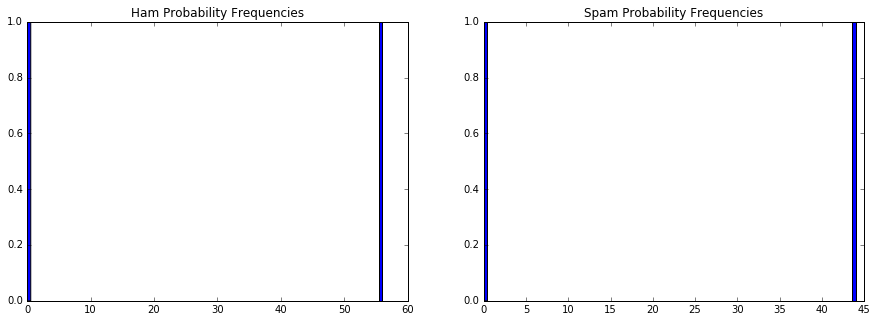

In [218]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# 44 spam and 56 ham all has posterior probability of 1
spam = (0,44)
ham = (0,56)
plt.figure(figsize=(15,5))
p = plt.subplot(1, 2, 1)
p.hist(ham,100)
plt.title('Ham Probability Frequencies')

p = plt.subplot(1, 2, 2)
p.hist(spam,100)
plt.title('Spam Probability Frequencies') 

## HW2.4 Use Laplace plus-one smoothing  <a name="2.4"></a>
[Back to Table of Contents](#TOC)

Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. 

In addition, compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

In [193]:
%%writefile reducer_t_em_s.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

tmp_word = None
smooth_factor = 1 # because smoothing
# because smoothing, so count from ONE 
tmp_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
# key is words, values are word probability at isChina class and nonChina class, respectively
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        continue
    
    # Used to count how many training items are at SPAM emails category
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    if tmp_word == word:        
        tmp_count[isSpam] += count
    else:
        if tmp_word:
            # count finish so save it
            wordcount[tmp_word] = tmp_count
        # begin new count for new word
        tmp_count = [smooth_factor, smooth_factor]
        tmp_count[isSpam] = count                
        tmp_word = word

# Last word count!
if tmp_word == word:    
    wordcount[tmp_word] = tmp_count
    
# calculate NB parameters, and write to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_Spam = sum(msgIDs.values())
n_Ham = n_msg - n_Spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_Ham/n_msg, 1.0*n_Spam/n_msg)

# conditional probabilities for each class
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t_em_s.py


In [194]:
!chmod a+x mapper_t_em.py
!chmod a+x reducer_t_em_s.py
!hdfs dfs -rm -r prob_em

# run training job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_t_em.py \
-reducer /home/cloudera/reducer_t_em_s.py \
-input /user/shihyu/enronemail_1h.txt \
-output prob_em

# clean up HDFS 
!chmod a+x mapper_c_em.py
!chmod a+x reducer_c_em.py

!hdfs dfs -rm -r Emails_classification_results_s
# run classification job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_c_em.py \
-reducer /home/cloudera/reducer_c_em.py \
-input /user/shihyu/enronemail_1h.txt \
-output Emails_classification_results_s

Deleted prob_em
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob5515545378449372430.jar tmpDir=null
16/09/10 06:03:36 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 06:03:36 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 06:03:37 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/10 06:03:38 INFO mapreduce.JobSubmitter: number of splits:2
16/09/10 06:03:38 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0053
16/09/10 06:03:38 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0053
16/09/10 06:03:38 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0053/
16/09/10 06:03:38 INFO mapreduce.Job: Running job: job_1473444507507_0053
16/09/10 06:03:44 INFO mapreduce.Job: Job job_1473444507507_0053 running in uber mode : false
16/09/10 06:03:44 INFO mapreduce.Job: 

In [195]:
!hdfs dfs -cat Emails_classification_results_s/part-00000

EMAIL ID	TRUTH	PREDICTION
0001.1999-12-10.farmer	0	0
0001.1999-12-10.kaminski	0	0
0001.2000-01-17.beck	0	0
0001.2000-06-06.lokay	0	0
0001.2001-02-07.kitchen	0	0
0001.2001-04-02.williams	0	0
0002.1999-12-13.farmer	0	0
0002.2001-02-07.kitchen	0	0
0002.2001-05-25.SA_and_HP	1	1
0002.2003-12-18.GP	1	1
0002.2004-08-01.BG	1	1
0003.1999-12-10.kaminski	0	0
0003.1999-12-14.farmer	0	0
0003.2000-01-17.beck	0	0
0003.2001-02-08.kitchen	0	0
0003.2003-12-18.GP	1	1
0003.2004-08-01.BG	1	1
0004.1999-12-10.kaminski	0	0
0004.1999-12-14.farmer	0	0
0004.2001-04-02.williams	0	0
0004.2001-06-12.SA_and_HP	1	1
0004.2004-08-01.BG	1	1
0005.1999-12-12.kaminski	0	0
0005.1999-12-14.farmer	0	0
0005.2000-06-06.lokay	0	0
0005.2001-02-08.kitchen	0	0
0005.2001-06-23.SA_and_HP	1	1
0005.2003-12-18.GP	1	1
0006.1999-12-13.kaminski	0	0
0006.2001-02-08.kitchen	0	0
0006.2001-04-03.williams	0	0
0006.2001-06-25.SA_and_HP	1	1
0006.2003-12-18.GP	1	1
0006.2004-08-01.BG	1	1
0007.1999-12-13.kaminski	0	0
0007.1999-12-14.farmer	0	0
0007.

###HW2.4 Discussion: Since smoothing essentially add noise to the data, and thus introduce some misclassification on the training set.

## HW2.5 Ignore rare words  <a name="2.5"></a>
[Back to Table of Contents](#TOC)

Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset. Report the error and the change in error. 

In [196]:
%%writefile reducer_t_em_I.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

tmp_word = None
smooth_factor = 0 # no smoothing
# because no smoothing, so count from zero for isChina and nonChina cases
tmp_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
# key is words, values are word probability at isChina class and nonChina class, respectively
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        continue
    
    # Used to count how many training items are at SPAM emails category
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    if tmp_word == word:        
        tmp_count[isSpam] += count
    else:
        if tmp_word:
            # count finish so save it
            wordcount[tmp_word] = tmp_count
        # begin new count for new word
        tmp_count = [smooth_factor, smooth_factor]
        tmp_count[isSpam] = count                
        tmp_word = word

# Last word count!
if tmp_word == word:    
    wordcount[tmp_word] = tmp_count
    
# calculate NB parameters, and write to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_Spam = sum(msgIDs.values())
n_Ham = n_msg - n_Spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_Ham/n_msg, 1.0*n_Spam/n_msg)

# conditional probabilities for each class
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    # only emit probability when the count (spam and ham together) is greater or equal than 3
    if sum(wordcount[key]) >= 3:
        print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t_em_I.py


In [200]:
%%writefile mapper_c_em_I.py
#!/usr/bin/python
import sys, re, string, subprocess
# read the probability prob_em from HDFS
prob = {}
cat = subprocess.Popen(["hadoop", "fs", "-cat", "/user/cloudera/prob_em/part-00000"], stdout=subprocess.PIPE)
### Prepare key (word) values (conditional prob at each class) pair 
for line in cat.stdout:    
    word, p0, p1 = line.split()
    prob[word] = [p0, p1]
    print '%s\n' % (word)

# get prior probability
prior = prob['prior_prob']

# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    msg = line.split('\t', 2)
    # skip bad message 
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output)
        # which has probability from training step
        if word in prob:
            print '%s\t%s\t%s\t%s\t%s\t%s' % (msgID, prob[word][0], prob[word][1], isSpam, prior[0], prior[1])

Overwriting mapper_c_em_I.py


In [201]:
!chmod a+x mapper_t_em.py
!chmod a+x reducer_t_em_I.py
!hdfs dfs -rm -r prob_em

# run training job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_t_em.py \
-reducer /home/cloudera/reducer_t_em_I.py \
-input /user/shihyu/enronemail_1h.txt \
-output prob_em

# clean up HDFS 
!chmod a+x mapper_c_em_I.py
!chmod a+x reducer_c_em.py

!hdfs dfs -rm -r Emails_classification_results_I
# run classification job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_c_em_I.py \
-reducer /home/cloudera/reducer_c_em.py \
-input /user/shihyu/enronemail_1h.txt \
-output Emails_classification_results_I

Deleted prob_em
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob2597624802238306615.jar tmpDir=null
16/09/10 06:39:40 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 06:39:41 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 06:39:41 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/10 06:39:41 INFO mapreduce.JobSubmitter: number of splits:2
16/09/10 06:39:41 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1473444507507_0059
16/09/10 06:39:42 INFO impl.YarnClientImpl: Submitted application application_1473444507507_0059
16/09/10 06:39:42 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1473444507507_0059/
16/09/10 06:39:42 INFO mapreduce.Job: Running job: job_1473444507507_0059
16/09/10 06:39:48 INFO mapreduce.Job: Job job_1473444507507_0059 running in uber mode : false
16/09/10 06:39:48 INFO mapreduce.Job: 

In [203]:
!hdfs dfs -cat Emails_classification_results_I/part-00000

EMAIL ID	TRUTH	PREDICTION
0001.1999-12-10.farmer	0	0
0001.1999-12-10.kaminski	0	0
0001.2000-01-17.beck	0	0
0001.2000-06-06.lokay	0	0
0001.2001-02-07.kitchen	0	0
0001.2001-04-02.williams	0	0
0002.1999-12-13.farmer	0	0
0002.2001-02-07.kitchen	0	0
0002.2001-05-25.SA_and_HP	1	1
0002.2003-12-18.GP	1	1
0002.2004-08-01.BG	1	1
0003.1999-12-10.kaminski	0	0
0003.1999-12-14.farmer	0	0
0003.2000-01-17.beck	0	0
0003.2001-02-08.kitchen	0	0
0003.2003-12-18.GP	1	1
0003.2004-08-01.BG	1	1
0004.1999-12-10.kaminski	0	0
0004.1999-12-14.farmer	0	0
0004.2001-04-02.williams	0	0
0004.2001-06-12.SA_and_HP	1	1
0004.2004-08-01.BG	1	1
0005.1999-12-12.kaminski	0	0
0005.1999-12-14.farmer	0	0
0005.2000-06-06.lokay	0	0
0005.2001-02-08.kitchen	0	0
0005.2001-06-23.SA_and_HP	1	1
0005.2003-12-18.GP	1	1
0006.1999-12-13.kaminski	0	0
0006.2001-02-08.kitchen	0	0
0006.2001-04-03.williams	0	0
0006.2001-06-25.SA_and_HP	1	1
0006.2003-12-18.GP	1	1
0006.2004-08-01.BG	1	1
0007.1999-12-13.kaminski	0	0
0007.1999-12-14.farmer	0	0
0007.

### HW2.5 Discussion: 
Similar to smoothing, ignoring small frequency words will remove some that only belong to one category.
Hence, the training error increases a bit. Compared to smoothing case, training error is smaller. 



##  HW2.6 Benchmark your code with the Python SciKit-Learn  <a name="2.6"></a>
[Back to Table of Contents](#TOC)


In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

X_train = []
Y_train = []

# read file
with open('enronemail_1h.txt', 'rU') as infile:
    for line in infile.readlines():
        try:
            email_id, label, subject, body = line.split('\t')
            X_train.append(subject + ' ' + body)
        except ValueError:
            email_id, label, body = line.split('\t')
            X_train.append(body)
        # extract only words from the combined subject and body text
        Y_train.append(int(label))

# Use the TfidVectorizer to create the feature vectors
vectorizer = TfidfVectorizer(token_pattern = "[\w']+")
vf = vectorizer.fit(X_train,Y_train)

clf_M = MultinomialNB()
clf_M.fit(vf.fit_transform(X_train), Y_train)
training_error_mnb = 1.0 - clf_M.score(vf.fit_transform(X_train), Y_train)

clf_B = BernoulliNB()
clf_B.fit(vf.fit_transform(X_train), Y_train)
training_error_bnb = 1.0 - clf_B.score(vf.fit_transform(X_train), Y_train)

print 'SK- multinomial NB error rate is : %.4f' %training_error_mnb
print 'SK- Bernoulli   NB error rate is : %.4f' %training_error_bnb

SK- multinomial NB error rate is : 0.0000
SK- Bernoulli   NB error rate is : 0.1800


### HW 2.6.1 Bernoulli Naive Bayes (OPTIONAL: note this exercise is a stretch HW and optional)

From SK-Learn, we have Multinomial NB with 0% error rate, and Bernoulli NB with 18% error rate. The difference 
is made by the properties of classifiers. Bernoulli NB classifier will focuses on the appearance of word, while Multinomial NB classifier will reflect the frequency of the word. At this example, Bernoulli classifier is better since, as for SPAM detection, the appearance of some words (keywords) is more important than the frequency. 

###  <span style="color:red">HW2.6.1 Results: </span>See execution above, performance summary:
|   |Training Error   |   
|---|:---:|
| SK-Learn Multinomial NB | 0% |
| SK-Learn Bernoulli NB  | 18% |
| Multinomial NB (HW2.4)| 2%  |
| Multinomial NB (HW2.5)| 1%  |

### HW2.6 Discussion:
  Since Bernoulli NB classifier emphaised on the appearance of word, while Multinomial NB classifier emphasizes on the frequency of the word, one would like to choose Bernoulli classifier for SPAM detection by focusing keywords appearing in SPAM emails. 


##  HW2.7 Preprocess the Entire Spam Dataset (OPTIONAL) <a name="2.7"></a>
[Back to Table of Contents](#TOC)

In [179]:
# Put the download folder at the same place of this notebook
from os import listdir
from os.path import isfile, join

# function to read one folder into text
def readmail(path, isSpam, handler):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for file_name in files:
        id = '.'.join(file_name.split('.')[:-2])
        f = open(path+file_name, 'r')
        mail = f.read().split('\n', 1)
        subject = mail[0].strip('Subject:').strip()
        body = ' '.join(mail[1].split()).strip()
        row = '%s\t%s\t%s\t%s' %(id, isSpam, subject, 'NA' if not body else body)
        f.close()
        handler.write(row + '\n')

# read two folder separately
text_file = open("train-Enron-1.txt", "w")
readmail('./enron1-Training-Data-RAW/ham/', '0', text_file)
readmail('./enron1-Training-Data-RAW/spam/', '1', text_file)
text_file.close()
print 'File train-Enron-1.txt was generated!'

!hdfs dfs -rm /user/shihyu/train-Enron-1.txt
!hdfs dfs -put train-Enron-1.txt /user/shihyu
print 'train-Enron-1.txt is uploaded to hdfs.'

File train-Enron-1.txt was generated!
rm: `/user/shihyu/train-Enron-1.txt': No such file or directory
train-Enron-1.txt is uploaded to hdfs.


## HW2.8 Build and evaluate a NB classifier on the  Entire Spam Dataset (OPTIONAL) <a name="2.8"></a>
[Back to Table of Contents](#TOC)

In [211]:
# clean up HDFS
!hdfs dfs -rm -r Emails_8_classification_results
!hdfs dfs -rm -r prob_em

# run trainning job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_t_em.py \
-reducer /home/cloudera/reducer_t_em_I.py \
-input /user/shihyu/train-Enron-1.txt \
-output prob_em

# run classification job
!hadoop jar /usr/lib/hadoop-mapreduce/hadoop-streaming.jar \
-mapper /home/cloudera/mapper_c_em_I.py \
-reducer /home/cloudera/reducer_c_em.py \
-input /user/shihyu/train-Enron-1.txt \
-output Emails_8_classification_results

rm: `Emails_8_classification_results': No such file or directory
Deleted prob_em
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob2182033911936835284.jar tmpDir=null
16/09/10 07:03:56 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 07:03:56 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/09/10 07:03:56 INFO mapred.FileInputFormat: Total input paths to process : 1
16/09/10 07:03:57 WARN hdfs.DFSClient: Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1281)
	at java.lang.Thread.join(Thread.java:1355)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:862)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:600)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:789)
16/09/10 07:03:57 INFO mapreduce.JobSubmitte

In [ ]:
!hdfs dfs -cat Emails_8_classification_results/part-00000


Since the result is too long, so I do not show total result about entries. Since Hadoop is executed successfully, for this train-Enron-1.txt data set, rrror rate is : 0.008509, and the Number of messages with zero probability are spam(1360), ham(3590).	

## HW2.8.1 OPTIONAL

In [217]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *

import csv, re, string
import numpy as np

# read email message, and organize training data
f = open('train-Enron-1.txt', 'r')
txt = f.read().strip()
f.close()
emails = txt.split('\n')
train_label = [msg.strip().split('\t', 2)[1] for msg in emails]
train_data = [msg.strip().split('\t', 2)[-1] for msg in emails]
# removing the funky characters
regex = re.compile('[%s]' % re.escape(string.punctuation))
train_data = [' '.join(regex.sub(' ', msg).split()).decode('latin-1') for msg in train_data]

# read test data
with open('enronemail_1h.txt', 'r') as f:
    reader = csv.reader(f, delimiter="\t")
    emails = list(reader)
test_label = [msg[1] for msg in emails]
test_data = [msg[2]+msg[3] if len(msg)==4 else msg[2] for msg in emails]
    

# feature vectorization
Vectorizeration = CountVectorizer()
Train = Vectorizeration.fit_transform(train_data) 
Test = Vectorizeration.transform(test_data)

# multinomial Naive Bayes Classifier from sklearn
clf_M = MultinomialNB()
clf_M.fit(Train, train_label)
pred_mnb = clf_M.predict(Test)
training_error_mnb = 1.0*sum(pred_mnb != test_label) / len(test_label)

# Bernoulli Naive Bayes Classifier from sklearn
clf_B = BernoulliNB()
clf_B.fit(Train, train_label)
pred_bnb = clf_B.predict(Test)
training_error_bnb = 1.0*sum(pred_bnb != test_label) / len(test_label)

print 'SK- multinomial NB error rate is : %.4f' %training_error_mnb
print 'SK- Bernoulli   NB error rate is : %.4f' %training_error_bnb

SK- multinomial NB error rate is : 0.0200
SK- Bernoulli   NB error rate is : 0.1900


### HW2.8.1 Discussion: Performance comparison shown by following table.
|   |Training Error   |   
|---|:---:|
| SK-Learn Multinomial NB | 0.02 |
| SK-Learn Bernoulli NB  | 0.19 |
| Multinomial NB (HW2.4)| 0.02  |
| Multinomial NB (HW2.5)| 0.01  |
